# Imports and load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
import lightgbm as lgb
from lightgbm import LGBMRegressor, Dataset

from hyperopt import hp, fmin, STATUS_OK, STATUS_FAIL, tpe, Trials, space_eval

pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('./data/train_trees.csv')
test_df = pd.read_csv('./data/test_trees.csv')
df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856


In [3]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, val_df.shape

((53754, 32), (5973, 32))

In [4]:
all_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
            'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
y_col = ['monthly_rent']
train_df = train_df[all_cols + y_col]
test_df = test_df[all_cols]
print(len(all_cols))
train_df.head()

21


,town,flat_type,flat_model,subzone,planning_area,region,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,...,age_bin,age,floor_area_sqm,shortest_dist_school,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt,sti,coe,monthly_rent
46682,queenstown,5 room,standard,dover,queenstown,central region,1,1,0,1,...,7,45.443836,117.0,0.490373,0.263181,0.486722,0.486722,0.536411,0.966841,4700
25386,hougang,executive,apartment,trafalgar,hougang,north-east region,1,3,2,3,...,3,22.016438,137.0,0.181800,0.153121,1.626200,1.626200,0.000000,0.042686,2200
27347,jurong west,4 room,model a,hong kah,jurong west,west region,1,1,1,3,...,6,37.273973,107.0,0.491038,0.522755,0.881589,0.881589,0.561993,0.126418,2100
25636,bishan,5 room,improved,bishan east,bishan,central region,0,1,1,3,...,6,36.024658,121.0,0.625651,0.518611,0.550143,0.550143,0.677828,0.778767,3000
23101,bukit merah,4 room,model a,kampong tiong bahru,bukit merah,central region,0,0,1,3,...,4,26.430137,108.0,0.426200,0.831461,0.822746,0.822746,0.536411,0.966841,4300


In [5]:
cat_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region', 'age_bin',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km']
train_df[cat_cols] = train_df[cat_cols].astype('category')
val_df[cat_cols] = val_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')

# Hyperopt setup

In [6]:
num_evals = 100
device = 'gpu'

#common hyperparameters sets for all models
n_estimators = [50, 100, 200, 300]
max_depth = [2, 3, 4, 5, 7, 10, 12]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0]
subsample = [0.4, 0.6, 0.8, 0.9, 1.0]
# col_subsample = [0.4, 0.6, 0.8, 0.9, 1.0] # cannot use for catboost when using GPU
col_subsample = [1.0]

### Class object for hyperparameter optimisation

In [7]:
class HPOptimiser(object):
    def __init__(self, train_pool, val_pool, train_labels=None, val_labels=None):
        self.train_pool = train_pool
        self.val_pool = val_pool
        self.train_labels = train_labels
        self.val_labels = val_labels

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.train_pool,
                eval_set=self.val_pool,
                **params['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def xgboost_reg(self, para):
        reg = xgb.train(params=para['reg_params'], dtrain=self.train_pool, evals=[(self.val_pool, 'eval')], **para['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def lightgbm_reg(self, para):
        reg = lgb.train(para['reg_params'], self.train_pool, **para['fit_params'])
        pred = reg.predict(self.val_pool.get_data().loc[:,:])
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label().copy(), pred))
        return {'loss': loss, 'status': STATUS_OK}

# Catboost

In [85]:
# Choose which subset of columns to use with the categorical columns first then set n_cat_cols to the number of categorical columns

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
# n_cat_cols = 13

x_col = ['flat_type', 'region', 'subzone',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
n_cat_cols = 3

### Test run before optimisation of hyperparameters

In [86]:

train_pool = Pool(train_df[x_col], train_df[y_col], cat_features=np.arange(n_cat_cols))
val_pool = Pool(val_df[x_col], val_df[y_col], cat_features=np.arange(n_cat_cols))
test_pool = Pool(test_df[x_col], cat_features=np.arange(n_cat_cols))

cat_model = CatBoostRegressor(iterations=50,
                          depth=4,
                          learning_rate=0.8,
                          bootstrap_type='Bernoulli',
                          subsample=0.8,
                          loss_function='RMSE',
                          task_type='GPU')
# train the model
cat_model.fit(train_pool, plot=True)

# evaluate on validation set
preds = cat_model.predict(val_pool)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 550.1321627	total: 4.73ms	remaining: 232ms
1:	learn: 522.5141006	total: 7.96ms	remaining: 191ms
2:	learn: 511.4862921	total: 11.1ms	remaining: 173ms
3:	learn: 507.1989434	total: 14.3ms	remaining: 164ms
4:	learn: 505.2944833	total: 18.3ms	remaining: 164ms
5:	learn: 502.5212936	total: 21.9ms	remaining: 161ms
6:	learn: 500.4681159	total: 25.1ms	remaining: 154ms
7:	learn: 498.7262326	total: 28.3ms	remaining: 149ms
8:	learn: 496.2908746	total: 31.5ms	remaining: 144ms
9:	learn: 495.7660574	total: 35.7ms	remaining: 143ms
10:	learn: 494.7704299	total: 39ms	remaining: 138ms
11:	learn: 494.1215120	total: 42.1ms	remaining: 133ms
12:	learn: 493.2039913	total: 45.5ms	remaining: 129ms
13:	learn: 492.5424705	total: 48.7ms	remaining: 125ms
14:	learn: 492.0318133	total: 52.7ms	remaining: 123ms
15:	learn: 491.6605175	total: 55.9ms	remaining: 119ms
16:	learn: 491.3111394	total: 59.2ms	remaining: 115ms
17:	learn: 491.0506108	total: 62.5ms	remaining: 111ms
18:	learn: 490.7000608	total: 66.1ms	rem

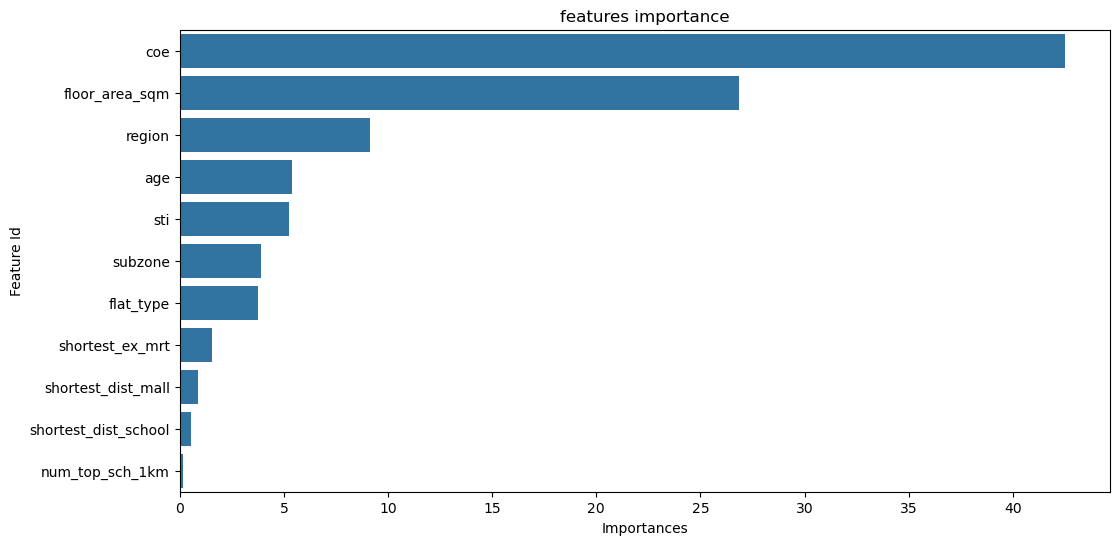

In [78]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

### Hyperparameter optimisation

In [11]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'n_estimators': hp.choice('n_estimators', n_estimators),
                         'max_depth': hp.choice('max_depth', max_depth),
                         'learning_rate': hp.choice('learning_rate', learning_rate),
                         'subsample': hp.choice('subsample', subsample),
                        #  'colsample_bylevel': hp.choice('colsample_bylevel', col_subsample),
                         'bootstrap_type': hp.choice('bootstrap_type', ['Poisson', 'Bernoulli', 'MVS']),
                         'l2_leaf_reg': hp.choice('l2_leaf_reg', [None, 1, 5, 10, 20]),
                         'loss_function': 'RMSE',
                         'eval_metric': 'RMSE',
                         'task_type': device.upper()}

catboost_fit_params = {'early_stopping_rounds': 10, 'verbose': False}

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catboost_fit_params
catboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [12]:
# hyperparamter optimisation
optimiser = HPOptimiser(train_pool, val_pool)
catboost_opt = optimiser.process(fn_name='catboost_reg', space=catboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [03:17<00:00,  1.97s/trial, best loss: 485.4353405949363]


In [13]:
# get best params
catboost_reg_params = space_eval(catboost_params['reg_params'], catboost_opt[0])
catboost_fit_params = space_eval(catboost_params['fit_params'], catboost_opt[0])
print(catboost_reg_params)
print(catboost_fit_params)

{'bootstrap_type': 'Bernoulli', 'eval_metric': 'RMSE', 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0, 'task_type': 'GPU'}
{'early_stopping_rounds': 10, 'verbose': False}


In [14]:
# get the best model
cat_model = CatBoostRegressor(**catboost_reg_params)
cat_model.fit(train_pool, plot=True, **catboost_fit_params)
preds = cat_model.predict(val_pool)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE on validation set is 484.94061974561913


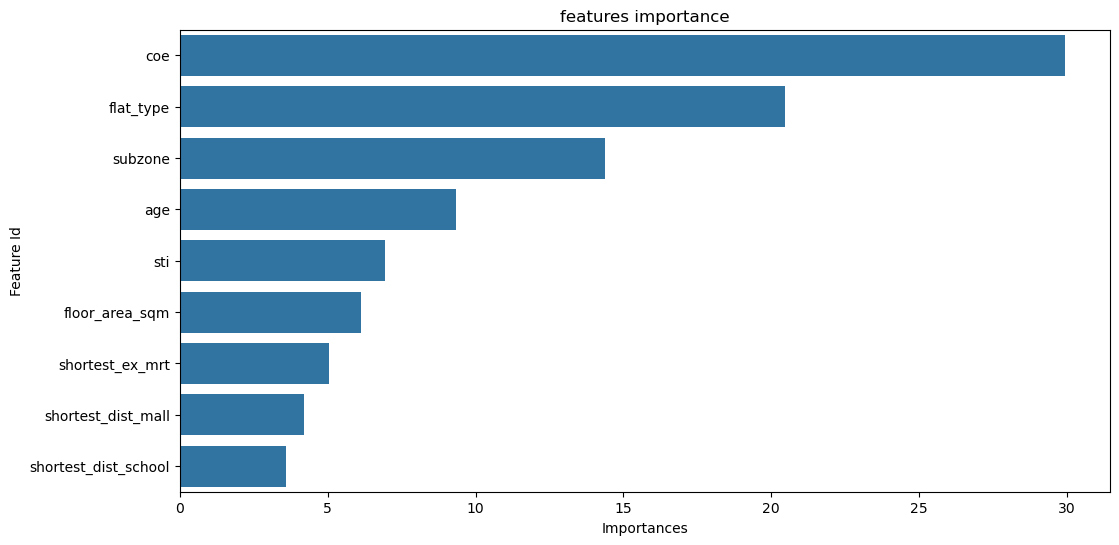

In [15]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

In [87]:
# predict on test set
preds = cat_model.predict(test_pool)
preds

array([3449.91153339, 2290.88132227, 2886.72880632, ..., 2125.0261744 ,
       3343.3684536 , 3702.60406046])

In [88]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_catboost.csv')

# XGBoost

In [18]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

x_col = ['flat_type', 'subzone',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'sti', 'coe']

### Test run before optimisation of hyperparameters

In [19]:
dtrain = DMatrix(data=train_df[x_col], label=train_df[y_col], enable_categorical=True)
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'device': 'gpu'}
xgb_cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10, verbose_eval=10)
xgb_cv

[0]	train-rmse:614.10533+0.95445	test-rmse:617.23824+5.43227
[10]	train-rmse:464.19849+0.89879	test-rmse:492.62856+2.07948
[20]	train-rmse:449.53435+0.64588	test-rmse:492.47628+2.09523
[23]	train-rmse:446.64760+0.62737	test-rmse:492.82733+1.94380


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,614.105327,0.954454,617.238237,5.432269
1,555.806122,1.058076,561.965814,4.906374
2,522.117109,0.854547,530.902745,4.665124
3,502.570639,0.830360,514.190268,4.227872
4,490.536696,1.015997,504.866476,3.665142
5,482.616067,0.999183,499.617644,3.104614
6,477.178100,0.848642,496.112495,2.801013
7,472.958478,0.593326,494.614866,2.511095
8,469.038971,0.615428,493.582327,2.146656
9,466.411224,0.868356,493.046574,2.092528


In [20]:
val_df[cat_cols] = val_df[cat_cols].astype('category')
deval = DMatrix(data=val_df[x_col], label=val_df[y_col], enable_categorical=True)
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100, early_stopping_rounds=10, evals=[(dtrain, 'train'), (deval, 'eval')], verbose_eval=10)

[0]	train-rmse:614.66187	eval-rmse:631.81167


[10]	train-rmse:468.15850	eval-rmse:539.07481
[17]	train-rmse:459.15724	eval-rmse:540.91518


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

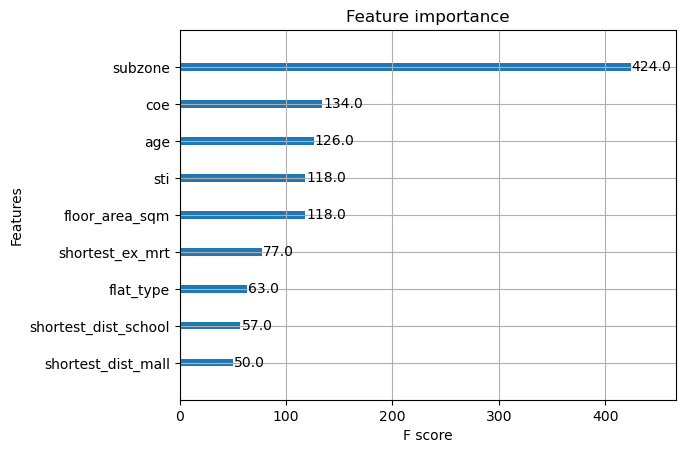

In [21]:
xgb.plot_importance(xgb_model, max_num_features=20)

### Hyperparamter optimisation

In [22]:
# xgboost hyperparameters to search
xgboost_hyperparams = { 'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', subsample),
                        # 'gamma': hp.uniform ('gamma', 0, 10),
                        # 'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        # 'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'booster': 'gbtree',
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'device': device}

xgboost_fit_params = {'early_stopping_rounds': 10,
                      'num_boost_round': hp.choice('num_boost_round', n_estimators),
                      'verbose_eval': False}

xgboost_params = dict()
xgboost_params['reg_params'] = xgboost_hyperparams
xgboost_params['fit_params'] = xgboost_fit_params
xgboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [23]:
# hyperparamter optimisation
optimiser = HPOptimiser(dtrain, deval)
xgboost_opt = optimiser.process(fn_name='xgboost_reg', space=xgboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

100%|██████████| 100/100 [01:22<00:00,  1.22trial/s, best loss: 508.417724609375]


In [24]:
# get best params
xgboost_reg_params = space_eval(xgboost_params['reg_params'], xgboost_opt[0])
xgboost_fit_params = space_eval(xgboost_params['fit_params'], xgboost_opt[0])
print(xgboost_reg_params)
print(xgboost_fit_params)

{'booster': 'gbtree', 'colsample_bytree': 0.4, 'device': 'gpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 10, 'objective': 'reg:squarederror', 'subsample': 0.6}
{'early_stopping_rounds': 10, 'num_boost_round': 200, 'verbose_eval': False}


In [25]:
# use best params to train XGBoost
xgb_model = xgb.train(params=xgboost_reg_params, dtrain=dtrain,
                      evals=[(deval, 'eval')],
                      num_boost_round=xgboost_fit_params['num_boost_round'],
                      early_stopping_rounds=xgboost_fit_params['early_stopping_rounds'],
                      verbose_eval=10)
preds = xgb_model.predict(deval)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

[0]	eval-rmse:713.63316


[10]	eval-rmse:629.77932
[20]	eval-rmse:577.25701
[30]	eval-rmse:548.76459
[40]	eval-rmse:532.17086
[50]	eval-rmse:522.25223
[60]	eval-rmse:516.12728
[70]	eval-rmse:512.19302
[80]	eval-rmse:509.50832
[90]	eval-rmse:508.92585
[100]	eval-rmse:508.62492
[110]	eval-rmse:508.37989
[114]	eval-rmse:508.41775
RMSE on validation set is 508.41772110858716


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

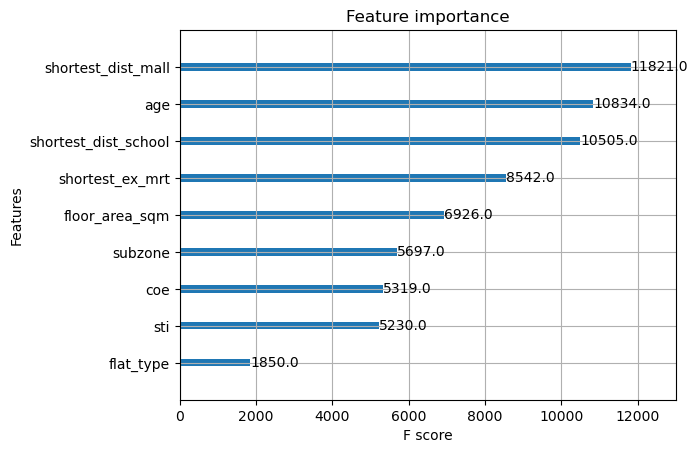

In [26]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [27]:
# predict on test set
dtest = DMatrix(data=test_df[x_col], enable_categorical=True)
preds = xgb_model.predict(dtest)
preds

array([3323.8599, 2958.715 , 3543.8042, ..., 3314.318 , 3419.959 ,
       3552.7798], dtype=float32)

In [28]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_xgboost.csv')

# LightGBM

In [29]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

x_col = ['flat_type', 'subzone',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'sti', 'coe']

In [30]:
lgb_train = Dataset(train_df[x_col], train_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()
lgb_eval = Dataset(val_df[x_col], val_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()

In [31]:
# lightgbm hyperparameters to search
lightgbm_hyperparams = {'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', col_subsample),
                        # 'gamma': hp.uniform ('gamma', 0, 10),
                        # 'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                        # 'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        # 'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'objective': 'regression',
                        'metric': 'rmse',
                        'device': device,
                        'verbose': -1}

lightgbm_fit_params = {'num_boost_round': hp.choice('num_boost_round', n_estimators)}#, 'verbose_eval': False}

lightgbm_params = dict()
lightgbm_params['reg_params'] = lightgbm_hyperparams
lightgbm_params['fit_params'] = lightgbm_fit_params
lightgbm_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [32]:
# hyperparamter optimisation
optimiser = HPOptimiser(lgb_train, lgb_eval)
lightgbm_opt = optimiser.process(fn_name='lightgbm_reg', space=lightgbm_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

100%|██████████| 100/100 [00:59<00:00,  1.69trial/s, best loss: 484.41942577260926]


In [33]:
# get best params
lgb_reg_params = space_eval(lightgbm_params['reg_params'], lightgbm_opt[0])
lgb_fit_params = space_eval(lightgbm_params['fit_params'], lightgbm_opt[0])
print(lgb_reg_params)
print(lgb_fit_params)

{'colsample_bytree': 1.0, 'device': 'gpu', 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'rmse', 'objective': 'regression', 'subsample': 0.4, 'verbose': -1}
{'num_boost_round': 200}


In [34]:
# get the best model
lgb_model = lgb.train(lgb_reg_params, lgb_train, **lgb_fit_params)
preds = lgb_model.predict(val_df.loc[:,x_col])
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

RMSE on validation set is 484.419425840093


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

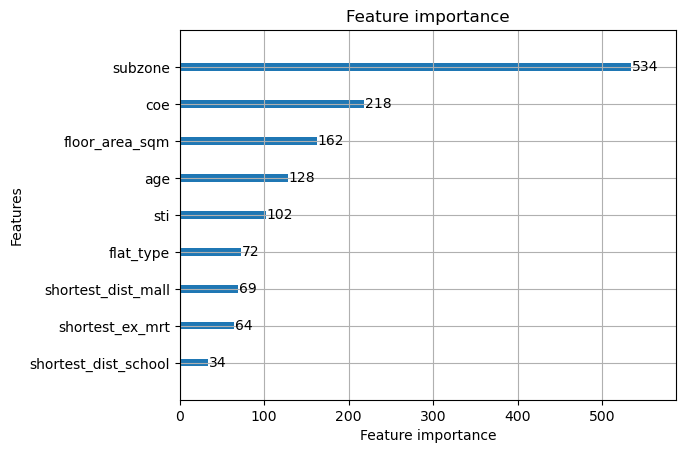

In [35]:
lgb.plot_importance(lgb_model, max_num_features=20)

In [36]:
# predict on test set
preds = lgb_model.predict(test_df.loc[:,x_col])
preds

array([2519.91779011, 2442.3434777 , 2897.57110708, ..., 2521.58361678,
       3248.00630288, 2815.9418558 ])

In [37]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_lightgbm.csv')